In [1]:
# need to run this command in order to install librosa 
!pip install llvmlite --ignore-installed


  Using cached llvmlite-0.34.0-cp36-cp36m-win_amd64.whl (15.9 MB)


In [2]:
!pip3 install librosa

In [3]:
!pip install tqdm
!pip install scikit-plot

In [4]:
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import scikitplot as skplt

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

# Audio
import librosa 
import librosa.display

#Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

### extract labels from audio files' names

In [5]:
dataset = []
# read all files inside folders sat_a and set_b
for folder in ['./dataset/set_a/**','./dataset/set_b/**']:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            # extracting labels fron file names
            Label = os.path.basename(filename).split('_')[0]
            
            # skip audio smaller than 4 second
            if librosa.get_duration(filename=filename) >= 4:
                if Label not in ['Aunlabelledtest','Bunlabelledtest']:
                    dataset.append({
                        'filename': filename,
                        'label': Label
                    })

dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
filename    404 non-null object
label       404 non-null object
dtypes: object(2)
memory usage: 9.5+ KB
None


### plot for the available diseases in the dataset 

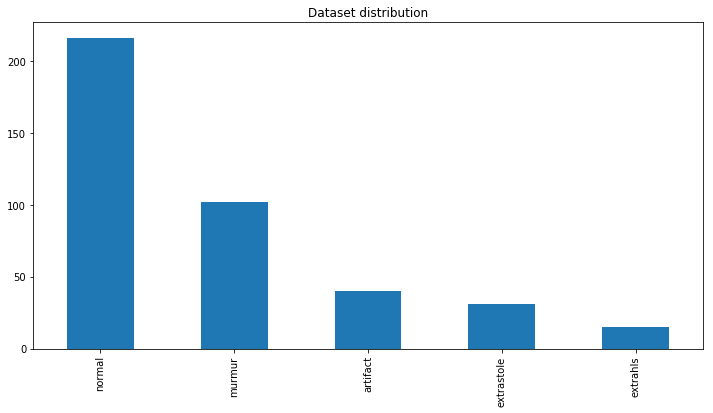

In [6]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title='Dataset distribution')
plt.show()

In [7]:
#split the dataset into trainig and testing
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print('Train: %i' %len(train))
print('Test: %i' %len(test))

Train: 323
Test: 81


### plot the waves of the types of heartbeat in 3 ways: waves, spectogram and mfcc

label:  murmur
label:  normal
label:  artifact
label:  extrahls
label:  extrastole


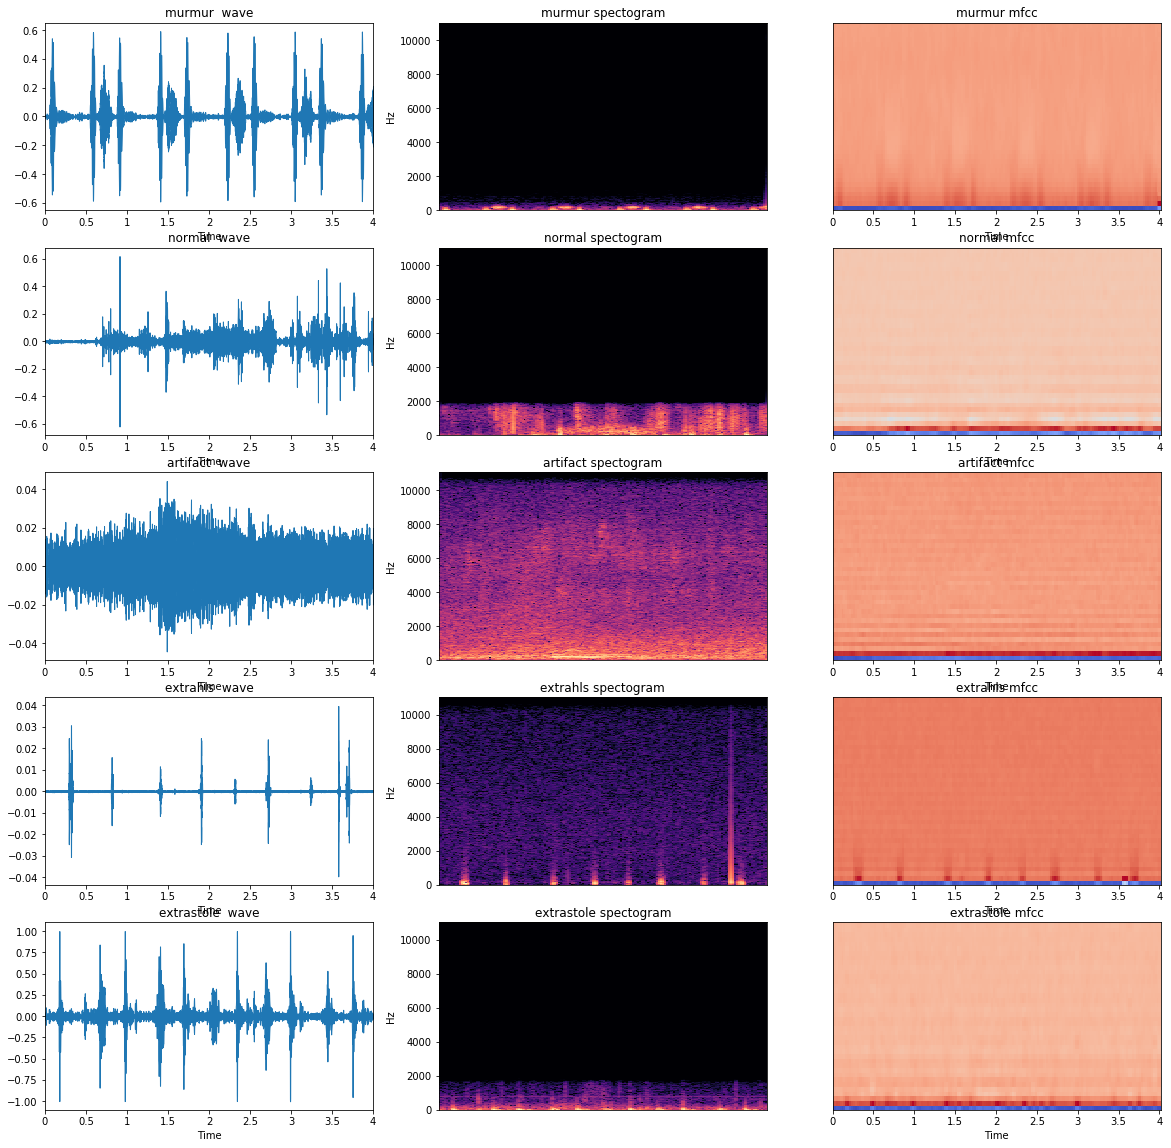

In [8]:
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():
    print('label: ', label)
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    # waves
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title('%s  wave' % label)
    librosa.display.waveplot(y, sr=sr)
    # spectogram
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title('%s spectogram' % label)
    # mfcc
    idx+=1
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title('%s mfcc' % label)
plt.show()

### data preprocessing

In [9]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc

In [10]:
x_train, x_test = [],[]
print('extract features from TRAIN and TEST dataset')
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))
    
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print('x_train: ',x_train.shape)
print('x_test: ',x_test.shape)
#convert labels into numerical values
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)



class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                   y_train)
#converting the class_weights array into dictionary to use it in model.fit method which requires a dictionary
weights = {i : class_weights[i] for i in range(len(class_weights))}

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
#convert labels in to one hot encoder vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('X train:', x_train.shape)
print('Y train:', y_train.shape)

print('\nX test:', x_test.shape)
print('Y test:', y_test.shape)


  0%|          | 0/323 [00:00<?, ?it/s]

extract features from TRAIN and TEST dataset


100%|██████████| 81/81 [00:14<00:00,  5.58it/s]

x_train:  (323, 40, 173)
x_test:  (81, 40, 173)
X train: (323, 40, 173, 1)
Y train: (323, 5)

X test: (81, 40, 173, 1)
Y test: (81, 5)


### building the model 

In [11]:
model = Sequential()
model.add(Conv2D(16, 2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(32, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

### training the model

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=300,
                    validation_data=(x_test, y_test),
                    class_weight=weights,
                    shuffle=False)
                    
                

Epoch 1/300
3/3 [==============================] - 2s 558ms/step - loss: 17.2429 - accuracy: 0.1424 - val_loss: 2.3263 - val_accuracy: 0.1975
Epoch 2/300
3/3 [==============================] - 1s 461ms/step - loss: 9.1205 - accuracy: 0.4180 - val_loss: 7.4608 - val_accuracy: 0.0741
Epoch 3/300
3/3 [==============================] - 1s 445ms/step - loss: 6.9453 - accuracy: 0.1269 - val_loss: 3.8696 - val_accuracy: 0.1605
Epoch 4/300
3/3 [==============================] - 1s 489ms/step - loss: 5.0846 - accuracy: 0.1238 - val_loss: 2.5645 - val_accuracy: 0.1481
Epoch 5/300
3/3 [==============================] - 1s 472ms/step - loss: 5.2025 - accuracy: 0.1950 - val_loss: 1.7109 - val_accuracy: 0.2716
Epoch 6/300
3/3 [==============================] - 2s 687ms/step - loss: 3.9143 - accuracy: 0.3870 - val_loss: 1.2605 - val_accuracy: 0.4568
Epoch 7/300
3/3 [==============================] - 2s 750ms/step - loss: 2.9825 - accuracy: 0.4923 - val_loss: 1.4124 - val_accuracy: 0.2346
Epoch 8/300


Epoch 59/300
3/3 [==============================] - 1s 390ms/step - loss: 0.6723 - accuracy: 0.4799 - val_loss: 1.1447 - val_accuracy: 0.5309
Epoch 60/300
3/3 [==============================] - 1s 396ms/step - loss: 0.7428 - accuracy: 0.4644 - val_loss: 1.1460 - val_accuracy: 0.5556
Epoch 61/300
3/3 [==============================] - 1s 429ms/step - loss: 0.7109 - accuracy: 0.5077 - val_loss: 1.1851 - val_accuracy: 0.5185
Epoch 62/300
3/3 [==============================] - 1s 413ms/step - loss: 0.7315 - accuracy: 0.5108 - val_loss: 1.1997 - val_accuracy: 0.5309
Epoch 63/300
3/3 [==============================] - 1s 367ms/step - loss: 0.7526 - accuracy: 0.4582 - val_loss: 1.1640 - val_accuracy: 0.5432
Epoch 64/300
3/3 [==============================] - 1s 410ms/step - loss: 0.6615 - accuracy: 0.5697 - val_loss: 1.1159 - val_accuracy: 0.5556
Epoch 65/300
3/3 [==============================] - 1s 383ms/step - loss: 0.6592 - accuracy: 0.5232 - val_loss: 1.0964 - val_accuracy: 0.5679
Epoch 

3/3 [==============================] - 1s 485ms/step - loss: 0.6296 - accuracy: 0.4985 - val_loss: 0.9818 - val_accuracy: 0.6049
Epoch 117/300
3/3 [==============================] - 1s 425ms/step - loss: 0.5838 - accuracy: 0.5325 - val_loss: 0.9852 - val_accuracy: 0.6049
Epoch 118/300
3/3 [==============================] - 1s 434ms/step - loss: 0.5692 - accuracy: 0.5820 - val_loss: 0.9675 - val_accuracy: 0.6173
Epoch 119/300
3/3 [==============================] - 1s 478ms/step - loss: 0.5670 - accuracy: 0.5759 - val_loss: 0.9429 - val_accuracy: 0.6667
Epoch 120/300
3/3 [==============================] - 1s 465ms/step - loss: 0.5636 - accuracy: 0.5851 - val_loss: 0.9455 - val_accuracy: 0.6296
Epoch 121/300
3/3 [==============================] - 1s 465ms/step - loss: 0.5759 - accuracy: 0.5542 - val_loss: 0.9570 - val_accuracy: 0.6296
Epoch 122/300
3/3 [==============================] - 1s 438ms/step - loss: 0.5784 - accuracy: 0.5387 - val_loss: 0.9772 - val_accuracy: 0.5926
Epoch 123/300

3/3 [==============================] - 1s 462ms/step - loss: 0.5026 - accuracy: 0.5944 - val_loss: 0.9426 - val_accuracy: 0.6173
Epoch 174/300
3/3 [==============================] - 1s 438ms/step - loss: 0.5046 - accuracy: 0.6099 - val_loss: 0.9552 - val_accuracy: 0.6420
Epoch 175/300
3/3 [==============================] - 1s 436ms/step - loss: 0.5195 - accuracy: 0.5542 - val_loss: 0.9598 - val_accuracy: 0.6173
Epoch 176/300
3/3 [==============================] - 1s 431ms/step - loss: 0.5264 - accuracy: 0.5139 - val_loss: 0.9705 - val_accuracy: 0.6420
Epoch 177/300
3/3 [==============================] - 1s 467ms/step - loss: 0.5442 - accuracy: 0.5882 - val_loss: 0.9520 - val_accuracy: 0.6296
Epoch 178/300
3/3 [==============================] - 1s 485ms/step - loss: 0.5225 - accuracy: 0.6006 - val_loss: 0.9530 - val_accuracy: 0.6173
Epoch 179/300
3/3 [==============================] - 1s 466ms/step - loss: 0.4986 - accuracy: 0.5728 - val_loss: 0.9377 - val_accuracy: 0.6420
Epoch 180/300

3/3 [==============================] - 1s 462ms/step - loss: 0.4847 - accuracy: 0.5789 - val_loss: 1.1420 - val_accuracy: 0.5802
Epoch 231/300
3/3 [==============================] - 1s 465ms/step - loss: 0.4881 - accuracy: 0.5418 - val_loss: 1.0765 - val_accuracy: 0.6173
Epoch 232/300
3/3 [==============================] - 1s 462ms/step - loss: 0.5040 - accuracy: 0.6811 - val_loss: 1.0269 - val_accuracy: 0.6420
Epoch 233/300
3/3 [==============================] - 1s 460ms/step - loss: 0.4757 - accuracy: 0.7028 - val_loss: 1.0232 - val_accuracy: 0.6420
Epoch 234/300
3/3 [==============================] - 1s 433ms/step - loss: 0.4748 - accuracy: 0.5882 - val_loss: 1.0268 - val_accuracy: 0.5926
Epoch 235/300
3/3 [==============================] - 1s 459ms/step - loss: 0.4628 - accuracy: 0.5913 - val_loss: 1.0135 - val_accuracy: 0.6296
Epoch 236/300
3/3 [==============================] - 1s 426ms/step - loss: 0.4918 - accuracy: 0.6192 - val_loss: 1.0552 - val_accuracy: 0.6173
Epoch 237/300

3/3 [==============================] - 1s 360ms/step - loss: 0.4321 - accuracy: 0.6347 - val_loss: 1.1249 - val_accuracy: 0.6420
Epoch 288/300
3/3 [==============================] - 1s 387ms/step - loss: 0.4448 - accuracy: 0.6811 - val_loss: 1.0722 - val_accuracy: 0.6420
Epoch 289/300
3/3 [==============================] - 1s 396ms/step - loss: 0.4352 - accuracy: 0.6997 - val_loss: 1.0930 - val_accuracy: 0.6420
Epoch 290/300
3/3 [==============================] - 1s 382ms/step - loss: 0.4460 - accuracy: 0.6502 - val_loss: 1.2285 - val_accuracy: 0.6420
Epoch 291/300
3/3 [==============================] - 1s 361ms/step - loss: 0.4591 - accuracy: 0.5820 - val_loss: 1.2006 - val_accuracy: 0.6049
Epoch 292/300
3/3 [==============================] - 1s 352ms/step - loss: 0.4311 - accuracy: 0.6409 - val_loss: 1.1127 - val_accuracy: 0.6296
Epoch 293/300
3/3 [==============================] - 1s 385ms/step - loss: 0.4282 - accuracy: 0.7245 - val_loss: 1.0942 - val_accuracy: 0.6420
Epoch 294/300

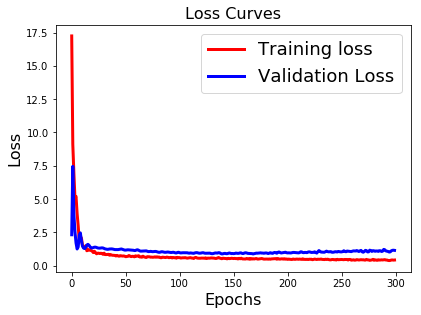

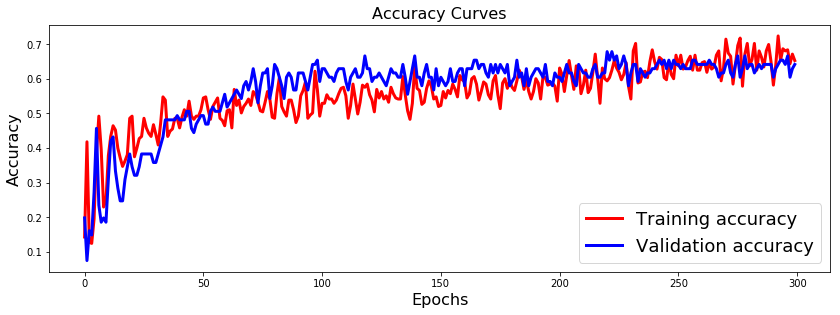

In [13]:
# Loss curves
plt.figure(figsize=[14,10])
plt.subplot(221)
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# accuracy curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [14]:
# save model and weights
model_name = 'heartbeat_disease.h5'
model.save(model_name)
print('Saved trained model at %s' % model_name)

scores = model.evaluate(x_test, y_test, verbose=1)
print('test loss:', scores[0])
print('test accuracy:', scores[1])

predictions = model.predict(x_test, verbose=1)


y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
print(classification_report(y_pred, y_true))

Saved trained model at heartbeat_disease.h5
3/3 [==============================] - 0s 24ms/step - loss: 1.1549 - accuracy: 0.6420
test loss: 1.1549206972122192
test accuracy: 0.6419752836227417
3/3 [==============================] - 0s 24ms/step
             precision    recall  f1-score   support

   artifact       0.78      0.88      0.82         8
   extrahls       0.75      0.43      0.55         7
 extrastole       0.50      0.25      0.33        12
     murmur       0.71      0.65      0.68        26
     normal       0.58      0.79      0.67        28

avg / total       0.64      0.64      0.63        81



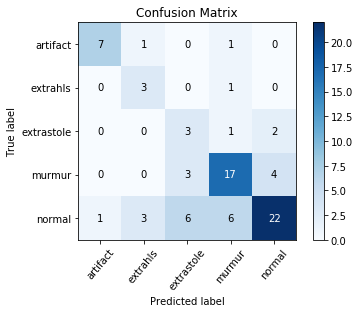

In [15]:
# Draw Confusion matrix in stylish design

skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=False)
plt.xticks(rotation=50)
plt.show()